## All You Need is Regression

When dealing with causal inference, we saw how there are two potential outcomes for each individual: \\(Y_0\\) is the outcome the individual would have if he or she didn't take the treatment and \\(Y_1\\) is the outcome if he or she took the treatment. The act of setting the treatment \\(T\\) to 0 or 1 materializes one of the potential outcomes and makes it impossible for us to ever know the other one. This leads to the fact that the individual treatment effect \\(\tau_i = Y_{1i} - Y_{0i}\\) is unknowable. 

$
Y_i = Y_{0i} + T_i(Y_{1i} - Y_{0i}) = Y_{0i}(1-T_i) + T_i Y_{1i}
$

So, for now, let's focus, on the simpler task of estimating the average causal effect. With this in mind, we are accepting the fact that some people respond better than others to the treatment, but we are also accepting that we can't know who they are. Instead, we will just try to see if the treatment works, **on average**. 

$
ATE = E[Y_1 - Y_0]
$

This will give us a simplified model, with a constant treatment effect \\(Y_{1i} = Y_{0i} + \kappa\\). If \\(\kappa\\) is positive, we will say that the treatment has, on average, a positive effect. Even if some people will respond badly to it, on average, the impact will be positive.

Let's also recall that we can't simply estimate \\(E[Y_1 - Y_0]\\) with the difference in mean \\(E[Y|T=1] - E[Y|T=0]\\) due to bias. Bias often arises when the treated and untreated are different for reasons other than the treatment itself. One way to see this is on how they differ in the potential outcome \\(Y_0\\)

$
E[Y|T=1] - E[Y|T=0] = \underbrace{E[Y_1 - Y_0|T=1]}_{ATET} + \underbrace{\{ E[Y_0|T=1] - E[Y_0|T=0]\}}_{BIAS}
$

Previously, we saw how we can eliminate bias with Random Experiments, or **Randomised Controlled Trial** (RCT) as they are sometimes called. RCT forces the treated and the untreated to be equal and that's why the bias vanishes. We also saw how to place uncertainty levels around our estimates for the treatment effect. Namely, we looked at the case of online versus face-to-face classrooms, where \\(T=0\\) represent face-to-face and \\(T=1\\) represent online. Students were randomly assigned to one of those 2 types of lectures and then, their performance on an exam was evaluated. We've built an A/B testing function that could compare both groups, provide the average treatment effect and even place a confidence interval around it.

Now, it's time to see that we can do all of that with the workhorse of causal inference: **Linear Regression**! Think of it this way. If comparing treated and untreated means whare an apple for dessert, linear regression would be cold and creamy tiramisu. Or if comparing treated and untreated is a sad and old loaf of white wonder bread, linear regression would be a crusty, soft and crumb country loaf sourdough baked by Chad Robertson himself.

![img](./data/img/linear-regression/you_vs.png)


Lets see how this beauty works. In the code below, we want to run the exact same analysis of comparing online vs face-to-face classes using the test score of their students. But instead of doing all that math of confidence intervals, we just run a regression. More specifically, we estimate the following model:

$
exam_i = \beta_0 + \kappa \ Online_i + u_i
$

Notice that \\(Online\\) is our treatment indication and hence, a dummy variable. It is zero when the treatment is face to face and 1 if it's online. With that in mind, we can see that linear regression will recover \\(E[Y|T=0] = \beta_0\\) and \\(E[Y|T=1] = \beta_0 + \kappa \\). \\(\kappa\\) will be our ATE.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import graphviz as gr
%matplotlib inline

data = pd.read_csv("data/online_classroom.csv").query("format_blended==0")
result = smf.ols('falsexam ~ format_ol', data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,78.5475,1.113,70.563,0.000,76.353,80.742
format_ol,-4.9122,1.680,-2.925,0.004,-8.223,-1.601


That's quite amazing. We not only are able to estimate the ATE, but we also get, for free, confidence intervals and P-Values out of it. More than that, we can see that regression is doing exactly what it supposed to do: comparing \\(E[Y|T=0]\\) and \\(E[Y|T=1]\\). The intercept is exactly the sample mean when \\(T=0\\), \\(E[Y|T=0]\\), and the coefficient of the online format is exactly the sample difference in means \\(E[Y|T=1] - E[Y|T=0]\\). Don't trust me? No problem. You can see for yourself:

In [2]:
(data
 .groupby("format_ol")
 ["falsexam"]
 .mean())

format_ol
0    78.547485
1    73.635263
Name: falsexam, dtype: float64

## Regression Theory

I don't intend to dive deep into how linear regression is constructed and estimated, but a little bit of theory will go a long way in explaining its power in causal inference. First of all, regression solves a theoretical best linear prediction problem. Let \\(\beta^*\\) be a vector of parameters:

$
\beta^* =\underset{\beta}{argmin} \ E[(Y_i - X_i'\beta)^2]
$


If you differentiate it and set it to zero, you will find that the solution to this problem is given by

$
\beta^* = E[X_i'X_i]^{-1}E[X_i' Y_i]
$

We can estimate this beta using the sample equivalent:

$
\hat{\beta} = (X'X)^{-1}X' Y
$

But don't take my word for it. If you are one of those that understand code better than formulas, try for yourself:

In [3]:
X = data[["format_ol"]].assign(intercep=1)
y = data["falsexam"]

def regress(y, X): return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y, X)
beta

array([-4.9122215 , 78.54748458])

The formulas above are pretty general. However, it pays off to study the case where we only have one regressor. In causal inference, we often want to estimate the causal impact of a variable \\(T\\) on an outcome \\(y\\). So, we use regression with this single variable to estimate this effect. Even if we include other variables in the model, they are usually just auxiliary. Adding other variables can help us estimate the causal effect of the treatment, but we are not very interested in estimating their parameters. 

With a single regressor variable \\(T\\), the parameter associated to it will be given by

$
\beta_1 = \dfrac{Cov(Y_i, T_i)}{Var(T_i)} 
$

If \\(T\\) is randomly assigned, \\(\beta_1\\) is the ATE.

In [4]:
kapa = data["falsexam"].cov(data["format_ol"]) / data["format_ol"].var()
kapa

-4.91222149822695

If we have more than one regressor, we can extend the following formula to accommodate that. Let's say those other variables are just auxiliary and that we are truly interested only in estimating the parameter \\(\kappa\\) associated to \\(T\\).

$
y_i = \beta_0 + \kappa T_i + \beta_1 X_{1i} + ... +\beta_k X_{ki} + u_i
$

\\(\kappa\\) can be obtained with the following formula

$
\kappa = \dfrac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})} 
$

where \\(\tilde{T_i}\\) is the residual from a regression of all other covariates \\(X_{1i} + ... + X_{ki}\\) on \\(T_i\\). Now, let's appreciate how cool this is. It means that the coefficient of a multivariate regression is the bivariate coefficient of the same regressor after accounting for the effect of other variables in the model. In causal infer term, \\(\kappa\\) is the bivariate coeficiente of \\(T\\) after having used all other variables to predict it.

That has a nice intuition behind it. If we can predict \\(T\\) using other variables, it means it's not random. However, we can make it so that \\(T\\) is as good as random once we control for other available variables. To do so, we use linear regression to predict it from the other variables and than we take the residuals of that regression \\(\tilde{T}\\). By definition, \\(\tilde{T}\\) cannot be predicted by the other variables \\(X\\) that we've already used to predict \\(T\\). Quite elegantly, \\(\tilde{T}\\) is a version of the treatment that is not associated with any other variable in \\(X\\).

By the way, this is also a proprietary of linear regression. The residual always orthogonal or uncorrelated with any of the variables in the model that created it:

In [5]:
e = y - X.dot(beta)
print("Orthogonality imply that the dot product is zero:", np.dot(e, X))
X[["format_ol"]].assign(e=e).corr()

Orthogonality imply that the dot product is zero: [-5.54223334e-13 -1.84741111e-12]


,format_ol,e
format_ol,1.000000e+00,1.963734e-16
e,1.963734e-16,1.000000e+00


And what is even cooler is that these properties don't depend on nothing! They are mathematical truths, regardless of how your data look like.

## Regression For Non-Random Data

So far, we worked with random experiment data but, as we know, those are hard to come by. Experiments are very expensive to conduct or simply infeasible. In the following example, we will try to estimate the impact of an additional year of education in hourly wage. As you might have guessed, it is extremely hard to conduct and experiment with education. You can't simply randomize people to 4, 8 or 12 years of education.

First, let's estimate a very simple model. We will regress log hourly wages on years of education. We use logs here so that hour parameter estimates have a percentage interpretation. With it, we will be able to say that 1 extra year of education yield a wage increase of x%. 

$
log(hwage)_i = \beta_0 + \beta_1 educ_i + u_i
$

In [6]:
wage = pd.read_csv("./data/wage.csv").dropna()
model_1 = smf.ols('np.log(wage) ~ educ', data=wage).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.9995,0.094,63.640,0.000,5.814,6.185
educ,0.0596,0.007,8.757,0.000,0.046,0.073


The estimate of \\(\beta_1\\) is 0.0529, with a 95% confidence interval of (0.040, 0.066). This means that this model predicts that wages will increase about 5.3% for every additional year of education. This percentage increase is inline with the belief that education impacts wages in an exponential fashion: we expect that going from 8 to 9 years of education to be more rewarding than going from 2 to 3 years.

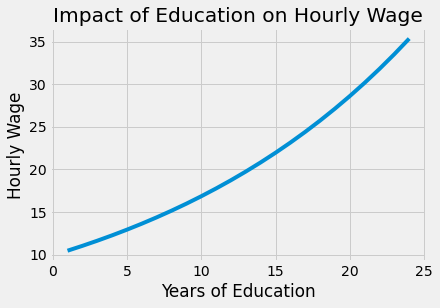

In [7]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

x = np.array(range(1, 25))
plt.plot(x, np.exp(2.2954 + 0.0529 * x))
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage")
plt.title("Impact of Education on Hourly Wage")
plt.show()

Of course, it is not because we can estimate this simple model that it's correct. Notice how I was carefully with my words saying it **predicts** wage from education. I never said that this prediction was causal. In fact, by now, you probably have very serious reasons to believe this model is biased. Since our data didn't come from a random experiment, we don't know if those that got more education are comparable to those that got less. Going even further, from our understanding of how the world works, we are very certain that they are not comparable. Namely, we can argue that those with more years of education probably have richer parents, and that the increase we are seeing in wages as we increase education is just a reflection of how the family wealth is associated with more years of education. Putting it in math terms, we think that \\(E[Y_0|T=0] < E[Y_0|T=1]\\), that is, those with more education would have higher income anyway, even without so many years of education. If you are really grim about education, you can argue that it can even *reduce* wages by keeping people out of the workforce and lowering their experience.

Fortunately, in our data, we have access to lots of other variables. We can see the parents' education `meduc`, `feduc`, the `IQ` score for that person, the number of years of experience `exper` and the tenure of the person in his or her current company `tenure`. We even have some dummy variables for marriage and black ethnicity. 

In [8]:
wage.head()

,wage,hours,lhwage,IQ,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc
0,769,40,2.956212,93,12,11,2,31,1,0,0,1,1,2.0,8.0,8.0
2,825,40,3.026504,108,14,11,9,33,1,0,0,1,1,2.0,14.0,14.0
3,650,40,2.788093,96,12,13,7,32,1,0,0,1,4,3.0,12.0,12.0
4,562,40,2.642622,74,11,14,5,34,1,0,0,1,10,6.0,6.0,11.0
6,600,40,2.708050,91,10,13,0,30,0,0,0,1,1,2.0,8.0,8.0


We can include all those extra variables in a model and estimate it:

$
log(hwage)_i = \beta_0 + \kappa \ educ_i + \pmb{\beta}X_i + u_i
$

To understand how this helps with the bias problem, let's recap the bivariate breakdown of multivariate linear regression.

$
\kappa = \dfrac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})} 
$

This formula says that we can predict `educ` from mother and father education, from IQ, from experience and so on. After we do it, we'll be left with a version of `educ`, \\(\tilde{educ}\\), which is uncorrelated with all the variables included previously. This will break down arguments such as "people that have more years of education have it because they have higher IQ. So it is not the case that education leads to higher wages. It is just the case that it is correlated with IQ, which is what drives waged". Well, if we include IQ in our model, then \\(\kappa\\) becomes the return of an additional year of education while keeping IQ fixed. Pause a little bit to understand what this implies. Even if we can't use randomised controlled trials to keep other factors equal between treated and untreated, regression can do this by including this factors in the model, even if the data is not random!

In [9]:
controls = ['IQ', 'exper', 'tenure', 'age', 'married', 'black',
            'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc']

X = wage[controls].assign(intercep=1)
t = wage["educ"]
y = wage["lhwage"]

beta_aux = regress(t, X)
t_tilde = t - X.dot(beta_aux)

kappa = t_tilde.cov(y) / t_tilde.var()
kappa

0.04114719101005262

This coefficient we've just estimated tells us that, for people with the same IQ, experience, tenure, age and so on, we should expect an additional year of education to be associated with a 4.11% increase in hourly wage. This confirms our suspicion that the first simple model with only `educ` was biases. It also confirms that this bias was overestimating the impact of education. Once we controlled for other factors, the estimated impact of education fell.

If we are wiser and use software that other people wrote instead of coding everything yourself, we can place a confidence interval around this estimate. 

In [10]:
model_2 = smf.ols('lhwage ~ educ +'+"+".join(controls), data=wage).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.1156,0.232,4.802,0.000,0.659,1.572
educ,0.0411,0.010,4.075,0.000,0.021,0.061
IQ,0.0038,0.001,2.794,0.005,0.001,0.006
exper,0.0153,0.005,3.032,0.003,0.005,0.025
tenure,0.0094,0.003,2.836,0.005,0.003,0.016
age,0.0086,0.006,1.364,0.173,-0.004,0.021
married,0.1795,0.053,3.415,0.001,0.076,0.283
black,-0.0801,0.063,-1.263,0.207,-0.205,0.044
south,-0.0397,0.035,-1.129,0.259,-0.109,0.029
urban,0.1926,0.036,5.418,0.000,0.123,0.262


## Omitted Variable or Confounding Bias

The question that remains is: is this parameter we've estimated causal? Unfortunately, we can't say for sure. We can argue that the first simple model that regress wage on education probably isn't. It omits important variables that are correlated both with education and with wages. Without controlling for them, the estimated impact of education is also capturing the impact of those other variables that were not included in the model.

To better understand how this bias work, let's suppose the true model for how education affect wage looks a bit like this

$
Wage_i = \alpha + \kappa \ Educ_i + A_i'\beta + u_i
$

wage is affected by education, which is measured by the size of \\(\kappa\\) and by additional ability factors, denoted as the vector \\(A\\). If we omit ability from our model, our estimate for \\(\kappa\\) will look like this:

$
\dfrac{Cov(Wage_i, Educ_i)}{Var(Educ_i)} = \kappa + \beta'\delta_{Ability}
$

where \\(\delta_{A}\\) is the vector of coefficients from the regression of \\(A\\) on \\(Educ\\)

It won't be exactly the \\(\kappa\\) that we want. Instead, it comes with this extra term \\(\beta'\delta_{A}\\). This term is the impact of the omitted \\(A\\) on \\(Wage\\), \\(\beta\\) times the impact of the omitted on the included \\(Educ\\). This is important for economists that Joshua Angrist made a mantra out of it so the students can recite in meditation:

```
"Short equals long plus the effect of omitted times the regression of omitted on included"
```

Here, the short regression is the one that omits variables, while the long is the one that includes them. This formula or mantra gives us further insight into the nature of bias. First, the bias term will be zero if the omitted variables have no impact on the dependent variable \\(Y\\). This makes total sense. I don't need to control for stuff that is irrelevant for wages when trying to understand the impact of education on it. Second, the bias term will also be zero if the omitted variables have no impact on the treatment variable. This also makes intuitive sense. If everything that impacts education has been included in the model, there is no way the estimated impact of education is mixed with a correlation from education on something else that also impacts wages. 

![img](data/img/linear-regression/confused_cat.png)

To put it more succinctly, we say that **there is no OVB if all the confounding variables are accounted for in the model**. We can also leverage our knowledge about causal graphs here. A confounding variable is one that **causes both the treatment and the outcome**. In the wage example, IQ is a confounder. People with high IQ tend to complete more years of education because it's easier for them, so we can say that IQ causes education. People with high IQ also tend to be naturally more productive and consequently have higher wages, so IQ also causes wage. Since confounders are variables that affect both the treatment and the outcome, we mark them with an arrow going to T and Y. Here, I've denoted them with \\(W\\). I've also marked positive causation with red and negative causation with blue.

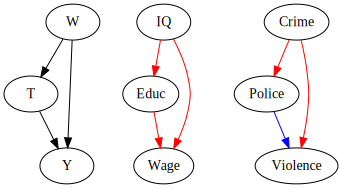

In [11]:
g = gr.Digraph()

g.edge("W", "T"), g.edge("W", "Y"), g.edge("T", "Y")

g.edge("IQ", "Educ", color="red"), g.edge("IQ", "Wage", color="red"), g.edge("Educ", "Wage", color="red")

g.edge("Crime", "Police", color="red"), g.edge("Crime", "Violence", color="red"), 
g.edge("Police", "Violence", color="blue")

g

Causal graphs are excellent to depict our understanding of the world and understand how confounding bias works. In our first example, we have a graph where education causes wage: more education leads to higher wages. However, IQ also causes wage and it also causes education: high IQ causes both more education and wage. So, if we don't account for IQ in our model, some of its effect on wage will flow through the correlation with education. That will make the impact of education look higher than it actually is. This is an example of positive bias.

Just to give another example, but with negative bias, consider the causal graph about the effect of police on city violence. What we usually see in the world is that cities with higher police force also have more violence. Does this mean that the police are causing the violence? Well, it could be, I don't think it's worth getting into that discussion here. But, there is also a strong possibility that there is a confounding variable causing us to see a biased version of the impact of police on violence. It could be that increasing police force decreases violence. But, a third variable crime, causes both more violence and more police force. If we don't account for it, the impact of crime on violence will flow through police force, making it look like it increases violence. This is an example of negative bias.

Causal graphs can also show us how both regression and randomized control trials are correct for confounding bias. RCT does so by severing the connection of the confounder to the treatment variable. By making \\(T\\) random, by definition, nothing can cause it. 

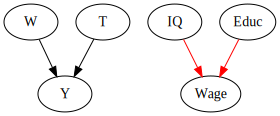

In [12]:
g = gr.Digraph()

g.edge("W", "Y"), g.edge("T", "Y")

g.edge("IQ", "Wage", color="red"), g.edge("Educ", "Wage", color="red")

g

Regression, on the other hand, does so by comparing the effect of \\(T\\) while maintaining the confounder \\(W\\) set to a fixed level. With regression, it is not the case that W cease to cause T and Y. It is just that it is held fixed, so it can't influence changes on T and Y.

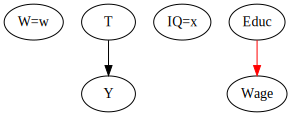

In [13]:
g = gr.Digraph()

g.node("W=w"), g.edge("T", "Y")
g.node("IQ=x"), g.edge("Educ", "Wage", color="red")

g

Now, back to our question, is the parameter we've estimated for the impact of `educ` on wage casual? That will depend on our ability to argue in favor or against that fact that all confounders have been included in the model. Personally, I think they haven't. For instance, we haven't included family wealth. Even if we included family education, that can only be seen as a proxy for wealth. We've also not accounted for factors like personal ambition. It could be ambition is what causes both more years of education and higher wage, so it is a confounder. This is to show that **causal inference with non-random or observational data should always be taken with a grain of salt**. We can never be sure that all confounders were accounted for.

## Key Ideas

We've covered a lot of ground with regression. We saw how regression can be used to perform A/B testing and how it conveniently gives us confidence intervals. Then, we moved to study how regression solves a prediction problem and it is the best linear approximation to the CEF. We've also discussed how, in the bivariate case, the regression treatment coefficient is the covariance between the treatment and the outcome divided by the variance of the treatment. Expanding to the multivariate case, we figured out how regression gives us a partialling out interpretation of the treatment coefficient: it can be interpreted as how the outcome would change with the treatment while keeping all other included variables constant. This is what economists love to refer as ceteris paribus.

Finally, we took a turn to understanding bias. We saw how `Short equals long plus the effect of omitted times the regression of omitted on included`. This shed some light to how bias comes to be. We discovered that the source of omitted variable bias is confounding: a variable that affects both the treatment and the outcome. Lastly, we used causal graphs to see how RCT and regression fixes confounding.

## References

I like to think of this entire series as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)